In [9]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

In [3]:
path = '/sciclone/geograd/stmorse/chs/Comp-HuSim'

records = []

with open(os.path.join(path, 'record.json'), 'r') as f:
    records.append(json.load(f))
with open(os.path.join(path, 'record2.json'), 'r') as f:
    records.append(json.load(f))

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
records[0]

{'0': {'event': {'Amina': 'Go to a coffee shop',
   'Gaston': 'Go to a coffee shop',
   'Aldo': 'Go to a coffee shop',
   'Zahra': 'Go to a coffee shop'},
  'transcript': [['Amina Osei',
    "Let's start by brainstorming ideas for a community event that brings people together around music, sustainability, and cultural heritage. I think it would be amazing to host a festival with traditional Sub-Saharan African music performances, workshops on urban farming, and a marketplace featuring local vendors selling sustainable products. What do you all think?"],
   ['Gaston Schneider',
    "I love the idea of a festival celebrating cultural heritage and sustainability, but I think we could also explore ways to incorporate local folklore into the event. Perhaps we could have a section dedicated to storytelling, where people can share tales from Luxembourgish mythology, or even a comic book station where attendees can create their own stories inspired by our town's history. This could not only br

In [7]:
embeddings = []

for record in records:
    for step, fields in record.items():
        print(f'{step}')
        sentences = [t[1] for t in fields['transcript']]
        embeddings.extend(model.encode(sentences))

embeddings = np.vstack(embeddings)
embeddings.shape

0
1
2
0
1
2


(24, 384)

In [11]:
et = TSNE(n_components=2, perplexity=15).fit_transform(embeddings)

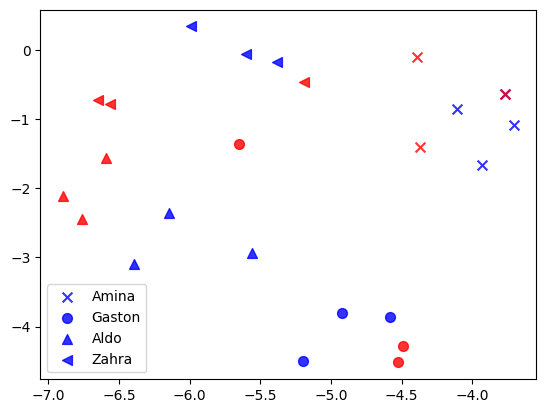

In [14]:
markers = ['x', 'o', '^', '<']
names   = ['Amina', 'Gaston', 'Aldo', 'Zahra']

for i, marker in enumerate(markers):
    idx1 = np.arange(i, 13, 4)
    idx2 = np.arange(12 + i, 24, 4)
    
    plt.scatter(et[idx1, 0], et[idx1, 1], s=50, c='b', marker=marker, alpha=0.8, label=names[i])
    plt.scatter(et[idx2, 0], et[idx2, 1], s=50, c='r', marker=marker, alpha=0.8)

plt.legend()